# HS04 model

## Phase 1

> The semantic component consisted of the 1,989 semantic features described above. These units were all connected to 50 units in the semantic cleanup apparatus...

- *50 sem_cleanup*

> The phonological representation consisted of the 200 phonolog-ical units (eight slots of 25 units each), which projected onto a set of 50 phonological cleanup units. These...

- *50 pho_cleanup*

> The semantic component mapped onto the phonological component via a set of 500 hidden units. There was feedback in both directions. 

- *500 sem_pho_hidden_units*
- *500 pho_sem_hidden_units*

> The phonological form of the target word was clamped on the phonological units for 2.66 units of time. Then a target signal was provided for the next 1.33 units of time, in which the network was required to retain the phonological pattern in the absence of external clamping. 

- *4 output_ticks* 

> In Harm and Seidenberg (1999), auto-connections were used to give the units a tendency to retain their value but gradually decay. To accomplish the task, the network had to learn enough of the statistical regularities of the representations to prevent this decay. In the current simulations, the idea is the same, but because continuous time units were used, auto-connections were not necessary to provide the units with a tendency to gradually decay; this was part of the units’ normal processing dynamics.

> HS99: This makes it easier to read weights as correlations between units. Each phonological unit has an auto-connection: a weight set to 0.75 and frozen to that value.

- *No auto-connection lock*

> HS04: These trials were devoted to training the semantic attractor. This task was constructed to be analogous to the phonological task: The pattern of semantic units corresponding to the selected word was clamped onto the units for 2.66 units of time, and the network was allowed to cycle. Then the semantic units were unclamped, and the network’s task was to maintain their activity in the face of the tendency of the units’ activity to decay for 1.33 units of time. 

- *Attractor clamped for 8 steps, free for last 4 steps*

## Phase 2

> The weights that were obtained at the end of the Phase 1 model were frozen and embedded in the larger reading model. Thus, only the connections from orthography to other units were trained in Phase 2. Freezing the weights is not strictly necessary; earlier work (Harm & Seidenberg, 1997) used a process of intermixing in which comprehension trials were used along with reading trials. Weight freezing has the same effect but is simpler and less computationally burdensome to implement. Intermixing is effective and real- istic but adds substantially to network training time.

- *Pretraining is necessary

> One set of 500 hidden units mediated the mapping from these orthographic units to semantics...

- *500 sem_hidden_units*

> ...a second set of 100 hidden units mediated the orth-phon pathway.

- *100 pho_hidden_units*

> To computationally instantiate the principle that the reading system is under pressure to perform rapidly as well as accurately, we injected error into the semantic and phonological representa- tions early, from time samples 2 to 12. 
- *11 output_ticks*

## Phase 3

- Modeling individual differences
- Simulating ERPs
- Link to reliance of OP vs OS
- Use equation to model semantic / phonetic input to P/S

In [1]:
%reload_ext lab_black
import pickle, os
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
from IPython.display import clear_output

import sys

sys.path.append("/home/jupyter/tf/src")
import meta, data_wrangling, modeling, metrics, evaluate

# Parameters block (for papermill)

In [2]:
code_name = "chang19_ssr_1k_test"
tf_root = "/home/jupyter/tf"

# Model architechture
ort_units = 119  # Phase 2 param (P2)
pho_units = 250
sem_units = 2446

hidden_os_units = 500  # P2
hidden_op_units = 100  # P2
hidden_ps_units = 500
hidden_sp_units = 500

pho_cleanup_units = 50
sem_cleanup_units = 50

pho_noise_level = 0.0  # P3
sem_noise_level = 0.0  # P3

activation = "sigmoid"
tau = 1 / 3
max_unit_time = 4.0
output_ticks = 4

# Training
sample_name = "chang_ssr"
oral_vocab_size = 1000

rng_seed = 53797
learning_rate = 0.01
n_mil_sample = 2.0
batch_size = 100
save_freq = 10

In [3]:
config_dict = {}

# Load global cfg variables into a dictionary for feeding into ModelConfig()
for v in meta.CORE_CONFIGS:
    try:
        config_dict[v] = globals()[v]
    except:
        raise

for v in meta.OPTIONAL_CONFIGS:
    try:
        config_dict[v] = globals()[v]
    except:
        pass

# Construct ModelConfig object
cfg = meta.ModelConfig(**config_dict)
cfg.save()
del config_dict

init from scratch
Saved config json to /home/jupyter/tf/models/chang19_ssr_1k_test/model_config.json


# Build model and all supporting components

In [4]:
tf.random.set_seed(cfg.rng_seed)
data = data_wrangling.MyData()
model = modeling.HS04Model(cfg)

sampler = data_wrangling.FastSampling(cfg, data)
generators = {
    "pho_sem": sampler.sample_generator(x="pho", y="sem"),
    "sem_pho": sampler.sample_generator(x="sem", y="pho"),
    "pho_pho": sampler.sample_generator(x="pho", y="pho"),
    "sem_sem": sampler.sample_generator(x="sem", y="sem"),
    "triangle": sampler.sample_generator(x="ort", y=["pho", "sem"]),
}

# Instantiate optimizer for each task
optimizers = {
    "pho_pho": tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate),
    "sem_sem": tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate),
    "pho_sem": tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate),
    "sem_pho": tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate),
    "triangle": tf.keras.optimizers.Adam(learning_rate=cfg.learning_rate),
}

# Instantiate loss_fn for each task
loss_fns = {
    "pho_pho": tf.keras.losses.BinaryCrossentropy(),
    "sem_sem": tf.keras.losses.BinaryCrossentropy(),
    "pho_sem": tf.keras.losses.BinaryCrossentropy(),
    "sem_pho": tf.keras.losses.BinaryCrossentropy(),
    "triangle": tf.keras.losses.BinaryCrossentropy(),
}

# Mean loss (for TensorBoard)
train_losses = {
    "pho_pho": tf.keras.metrics.Mean("train_loss_pho_pho", dtype=tf.float32),
    "sem_sem": tf.keras.metrics.Mean("train_loss_sem_sem", dtype=tf.float32),
    "pho_sem": tf.keras.metrics.Mean("train_loss_pho_sem", dtype=tf.float32),
    "sem_pho": tf.keras.metrics.Mean("train_loss_sem_pho", dtype=tf.float32),
    "triangle": tf.keras.metrics.Mean("train_loss_triangle", dtype=tf.float32),
}

# Train metrics
train_acc = {
    "pho_pho": metrics.PhoAccuracy("acc_pho_pho"),
    "sem_sem": metrics.RightSideAccuracy("acc_sem_sem"),
    "pho_sem": metrics.RightSideAccuracy("acc_pho_sem"),
    "sem_pho": metrics.PhoAccuracy("acc_sem_pho"),
    "triangle_pho": metrics.PhoAccuracy("acc_triangle_pho"),
    "triangle_sem": metrics.RightSideAccuracy("acc_triangle_sem"),
}

==========Orthographic representation==========
ort_train shape: (5861, 119)
ort_strain shape: (160, 119)
ort_grain shape: (120, 119)
ort_taraban shape: (192, 119)
ort_glushko shape: (86, 119)

==========Phonological representation==========
38  phonemes:  dict_keys(['_', 'p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 'T', 'D', 's', 'z', 'S', 'Z', 'h', 'C', 'J', 'm', 'n', 'l', 'r', 'w', 'y', 'i', 'I', 'e', 'E', 'a', '@', 'u', 'U', 'o', '^', 'Y', 'A', 'W', 'O'])
pho_train shape: (5861, 250)
pho_strain shape: (160, 250)
pho_large_grain shape: (120, 250)
pho_small_grain shape: (120, 250)
pho_taraban shape: (192, 250)
pho_glushko shape: (86, 250)

==========Semantic representation==========
sem_train shape: (5861, 2446)
sem_strain shape: (160, 2446)


# Train step for each task

In [5]:
# For some low-level technical reason, each sub-task must be trained with separate optimizer,
# instead of sharing the same optimizer instance (https://github.com/tensorflow/tensorflow/issues/27120)


def get_train_step():
    """Wrap universal train step creator"""

    @tf.function
    def train_step(x, y, model, task, loss_fn, optimizer, train_metric, train_losses):

        train_weights_name = [x + ":0" for x in modeling.WEIGHTS_AND_BIASES[task]]
        train_weights = [x for x in model.weights if x.name in train_weights_name]

        with tf.GradientTape() as tape:
            y_pred = model(x, training=True)
            loss_value = loss_fn(y, y_pred)

        grads = tape.gradient(loss_value, train_weights)
        optimizer.apply_gradients(zip(grads, train_weights))

        # Mean loss for Tensorboard
        train_losses.update_state(loss_value)

        # Metric for last time step (output first dimension is time ticks, from -cfg.output_ticks to end)
        train_metric.update_state(tf.cast(y[-1], tf.float32), y_pred[-1])

    return train_step


train_steps = {
    "pho_pho": get_train_step(),
    "pho_sem": get_train_step(),
    "sem_sem": get_train_step(),
    "sem_pho": get_train_step(),
}

### Triangle model (Phase 2 in HS04) specific train step
Because we have both P and S output, the trainstep need to cater for this dual output.

In [6]:
@tf.function
def train_step_triangle(
    x,
    y,
    model,
    task,
    loss_fn,
    optimizer,
    train_metric_pho,
    train_metric_sem,
    train_losses,
):

    train_weights_name = [x + ":0" for x in modeling.WEIGHTS_AND_BIASES[task]]
    train_weights = [x for x in model.weights if x.name in train_weights_name]

    with tf.GradientTape() as tape:
        pho_pred, sem_pred = model(x, training=True)
        loss_value_pho = loss_fn(y[0], pho_pred)
        loss_value_sem = loss_fn(y[1], sem_pred)
        loss_value = loss_value_pho + loss_value_sem

    grads = tape.gradient(loss_value, train_weights)
    optimizer.apply_gradients(zip(grads, train_weights))

    # Mean loss for Tensorboard
    train_losses.update_state(loss_value)

    # Metric for last time step (output first dimension is time ticks, from -cfg.output_ticks to end)
    train_metric_pho.update_state(tf.cast(y[0][-1], tf.float32), pho_pred[-1])
    train_metric_sem.update_state(tf.cast(y[1][-1], tf.float32), sem_pred[-1])


train_steps["triangle"] = train_step_triangle

# Train model

In [7]:
import time

model.build()
phase1_tasks = ["pho_sem", "sem_pho", "pho_pho", "sem_sem"]
phase1_tasks_probability = [0.4, 0.4, 0.1, 0.1]

# TensorBoard writer
train_summary_writer = tf.summary.create_file_writer(cfg.path["tensorboard_folder"])

for epoch in range(cfg.total_number_of_epoch):
    start_time = time.time()

    for step in range(cfg.steps_per_epoch):
        # Intermix tasks (Draw a new task in each step)
        task = np.random.choice(phase1_tasks, p=phase1_tasks_probability)
        model.set_active_task(task)
        x_batch_train, y_batch_train = next(generators[task])

        if task == "triangle":
            train_steps[task](
                x_batch_train,
                y_batch_train,
                model,
                task,
                loss_fns[task],
                optimizers[task],
                train_acc["triangle_pho"],
                train_acc["triangle_sem"],
                train_losses[task],
            )
        else:
            train_steps[task](
                x_batch_train,
                y_batch_train,
                model,
                task,
                loss_fns[task],
                optimizers[task],
                train_acc[task],
                train_losses[task],
            )

    # End of epoch operations

    ## Log all scalar metrics (losses and metrics)and histogram (weights and biases) to tensorboard
    with train_summary_writer.as_default():
        [
            tf.summary.scalar(f"loss_{x}", train_losses[x].result(), step=epoch)
            for x in train_losses.keys()
        ]
        [
            tf.summary.scalar(f"acc_{x}", train_acc[x].result(), step=epoch)
            for x in train_acc.keys()
        ]
        [tf.summary.histogram(f"{x.name}", x, step=epoch) for x in model.weights]

    ## Print status
    compute_time = time.time() - start_time
    print(f"Epoch {epoch + 1} trained for {compute_time:.0f}s")
    print(
        "Losses:",
        [f"{x}: {train_losses[x].result().numpy()}" for x in phase1_tasks],
    )
    clear_output(wait=True)

    ## Save weights
    if (epoch < 10) or ((epoch + 1) % 10 == 0):
        weight_path = cfg.path["weights_checkpoint_fstring"].format(epoch=epoch + 1)
        model.save_weights(weight_path, overwrite=True, save_format="tf")

    ## Reset metric and loss
    [train_losses[x].reset_states() for x in train_losses.keys()]
    [train_acc[x].reset_states() for x in train_acc.keys()]

# End of training ops
# model.save(cfg.path["save_model_folder"])
print("Done")

Done


# Evaluate model

## PS performance during oral phase

In [8]:
data = data_wrangling.MyData()
model = modeling.HS04Model(cfg)
model.build()
model.set_active_task("pho_sem")

# Instantiate metrics
ps_homophone_acc = metrics.RightSideAccuracy("ps_homophone_acc")
ps_non_homophone_acc = metrics.RightSideAccuracy("ps_non_homophone_acc")
ps_train_acc = metrics.RightSideAccuracy("ps_train_acc")


def my_eval(model, cfg, x, y, metrics):
    pred_y = model([x] * cfg.n_timesteps)

    output = []
    for metric in metrics:
        metric.update_state(y, pred_y[-1])
        output.append(metric.result().numpy())

    return output


def eval_oral_phase_ps(checkpoint):

    model.load_weights(checkpoint)

    non_homophone = my_eval(
        model,
        cfg,
        data.testsets["non_homophone"]["pho"],
        data.testsets["non_homophone"]["sem"],
        [ps_non_homophone_acc],
    )

    homophone = my_eval(
        model,
        cfg,
        data.testsets["homophone"]["pho"],
        data.testsets["homophone"]["sem"],
        [ps_homophone_acc],
    )

    all_train = my_eval(
        model,
        cfg,
        data.pho_train,
        data.sem_train,
        [ps_train_acc],
    )

    return non_homophone[0], homophone[0], all_train[0]

==========Orthographic representation==========
ort_train shape: (5861, 119)
ort_strain shape: (160, 119)
ort_grain shape: (120, 119)
ort_taraban shape: (192, 119)
ort_glushko shape: (86, 119)

==========Phonological representation==========
38  phonemes:  dict_keys(['_', 'p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 'T', 'D', 's', 'z', 'S', 'Z', 'h', 'C', 'J', 'm', 'n', 'l', 'r', 'w', 'y', 'i', 'I', 'e', 'E', 'a', '@', 'u', 'U', 'o', '^', 'Y', 'A', 'W', 'O'])
pho_train shape: (5861, 250)
pho_strain shape: (160, 250)
pho_large_grain shape: (120, 250)
pho_small_grain shape: (120, 250)
pho_taraban shape: (192, 250)
pho_glushko shape: (86, 250)

==========Semantic representation==========
sem_train shape: (5861, 2446)
sem_strain shape: (160, 2446)


In [9]:
from tqdm import tqdm

results = []
for chkpt in tqdm(cfg.path["weights_list"]):
    results.append(eval_oral_phase_ps(chkpt))

df = pd.DataFrame(results)

100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


<AxesSubplot:xlabel='epoch'>

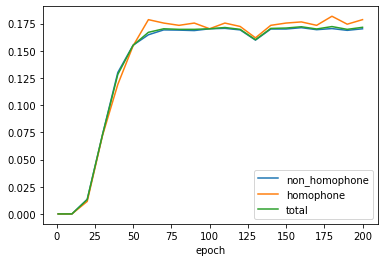

In [10]:
df.columns = ["non_homophone", "homophone", "total"]
saved_n = len(cfg.path["weights_list"])
df["epoch"] = np.concatenate(
    [np.linspace(1, 10, 10), np.linspace(20, cfg.total_number_of_epoch, saved_n - 10)]
)

df.plot(x="epoch")

## SP performance during oral phase

In [11]:
data = data_wrangling.MyData()
model = modeling.HS04Model(cfg)
model.build()
model.set_active_task("sem_pho")

# Instantiate metrics
sp_homophone_acc = metrics.RightSideAccuracy("sp_homophone_acc")
sp_non_homophone_acc = metrics.RightSideAccuracy("sp_non_homophone_acc")
sp_train_acc = metrics.RightSideAccuracy("sp_train_acc")


def eval_oral_phase_sp(checkpoint):

    model.load_weights(checkpoint)

    non_homophone = my_eval(
        model,
        cfg,
        data.testsets["non_homophone"]["sem"],
        data.testsets["non_homophone"]["pho"],
        [sp_non_homophone_acc],
    )

    homophone = my_eval(
        model,
        cfg,
        data.testsets["homophone"]["sem"],
        data.testsets["homophone"]["pho"],
        [sp_homophone_acc],
    )

    all_train = my_eval(
        model,
        cfg,
        data.sem_train,
        data.pho_train,
        [sp_train_acc],
    )

    return non_homophone[0], homophone[0], all_train[0]

==========Orthographic representation==========
ort_train shape: (5861, 119)
ort_strain shape: (160, 119)
ort_grain shape: (120, 119)
ort_taraban shape: (192, 119)
ort_glushko shape: (86, 119)

==========Phonological representation==========
38  phonemes:  dict_keys(['_', 'p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 'T', 'D', 's', 'z', 'S', 'Z', 'h', 'C', 'J', 'm', 'n', 'l', 'r', 'w', 'y', 'i', 'I', 'e', 'E', 'a', '@', 'u', 'U', 'o', '^', 'Y', 'A', 'W', 'O'])
pho_train shape: (5861, 250)
pho_strain shape: (160, 250)
pho_large_grain shape: (120, 250)
pho_small_grain shape: (120, 250)
pho_taraban shape: (192, 250)
pho_glushko shape: (86, 250)

==========Semantic representation==========
sem_train shape: (5861, 2446)
sem_strain shape: (160, 2446)


100%|██████████| 29/29 [00:50<00:00,  1.73s/it]


<AxesSubplot:xlabel='epoch'>

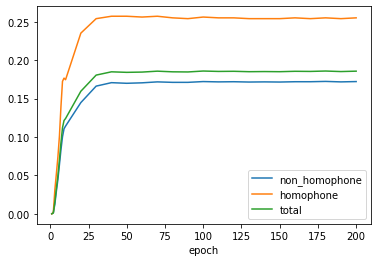

In [12]:
from tqdm import tqdm

results = []
for chkpt in tqdm(cfg.path["weights_list"]):
    results.append(eval_oral_phase_sp(chkpt))

df = pd.DataFrame(results)

df.columns = ["non_homophone", "homophone", "total"]
saved_n = len(cfg.path["weights_list"])
df["epoch"] = np.concatenate(
    [np.linspace(1, 10, 10), np.linspace(20, cfg.total_number_of_epoch, saved_n - 10)]
)

df.plot(x="epoch")

In [13]:
# local ssh to cloud tensorboard
# gcloud compute ssh tensorflow-2-4-20210120-000018 --zone us-east4-b -- -L 6006:localhost:6006

In [14]:
# !tensorboard dev upload --logdir tensorboard_log